In [6]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from datasets import BarcelonaDataModule, BarcelonaDataset
import matplotlib.pyplot as plt
# Définir les transformations (resize, normalisation...)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Charger les images
data_dir = 'barcelona/barcelona'
datamodule = BarcelonaDataModule(root=data_dir, batch_size=32, num_workers=0)
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0)
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [7]:
model = models.resnet50(pretrained=True)

# Remplacer la dernière couche fully connected
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [8]:
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
from tqdm import tqdm  
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase]):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

Epoch 1/5


100%|██████████| 452/452 [09:10<00:00,  1.22s/it]


train Loss: 0.1674 Acc: 0.9501


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


test Loss: 0.0650 Acc: 0.9775
Epoch 2/5


100%|██████████| 452/452 [09:11<00:00,  1.22s/it]


train Loss: 0.0612 Acc: 0.9804


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


test Loss: 0.0773 Acc: 0.9834
Epoch 3/5


100%|██████████| 452/452 [04:03<00:00,  1.86it/s]


train Loss: 0.0483 Acc: 0.9850


100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


test Loss: 0.0639 Acc: 0.9834
Epoch 4/5


100%|██████████| 452/452 [04:04<00:00,  1.85it/s]


train Loss: 0.0313 Acc: 0.9903


100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


test Loss: 0.0668 Acc: 0.9763
Epoch 5/5


100%|██████████| 452/452 [03:38<00:00,  2.07it/s]


train Loss: 0.0271 Acc: 0.9913


100%|██████████| 27/27 [00:07<00:00,  3.58it/s]

test Loss: 0.0758 Acc: 0.9787


In [12]:
torch.save(model.state_dict(), "resnet_model_weights.pth")

100%|██████████| 27/27 [00:07<00:00,  3.81it/s]


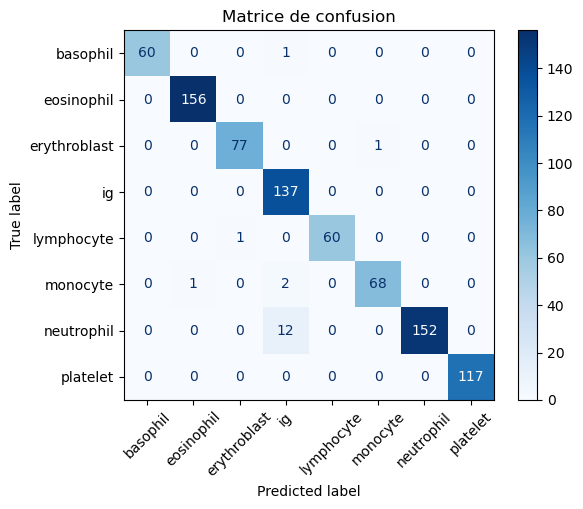

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, class_names, device="cuda"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()


# utiliser tensorboard
# Exemple d’appel
compute_confusion_matrix(model, dataloaders['test'], image_datasets['test'].classes)

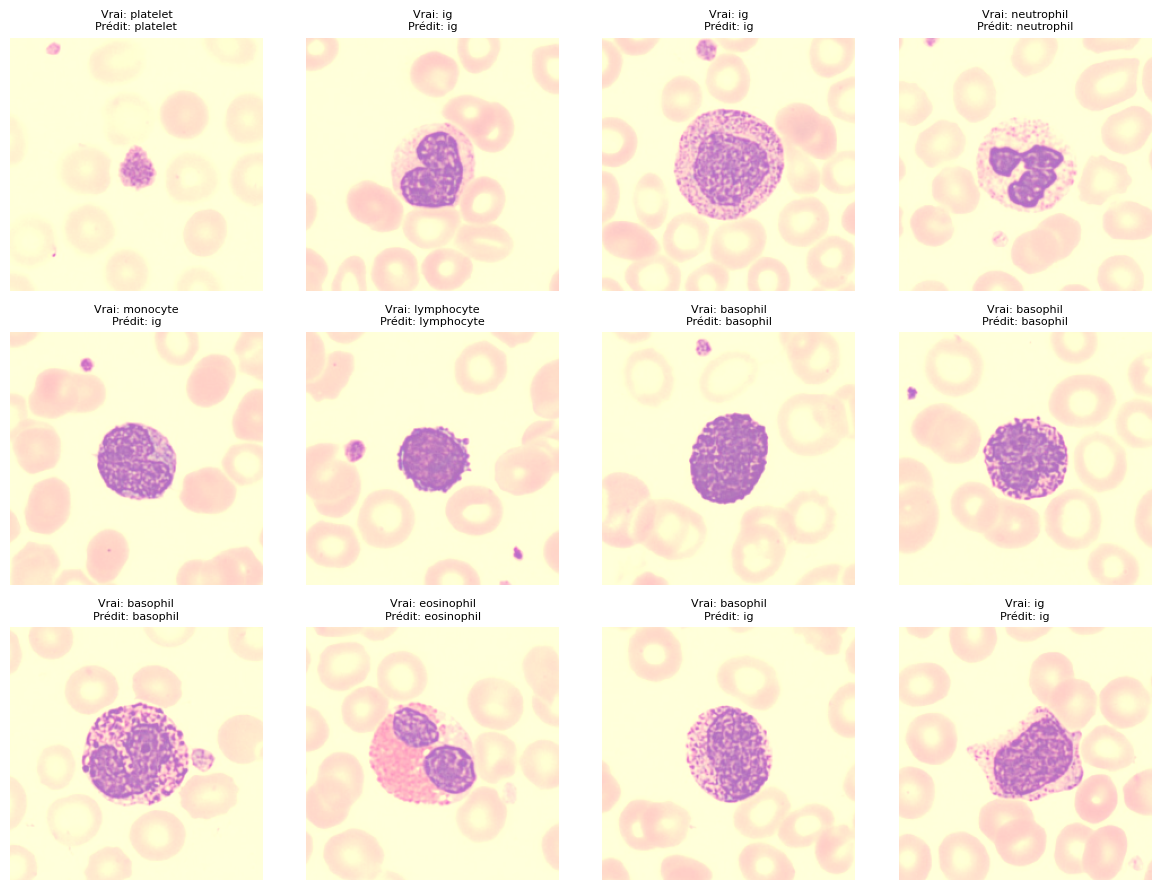

In [14]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = images[i].cpu().permute(1, 2, 0) * torch.tensor(datamodule.std) + torch.tensor(datamodule.mean)
        img = img.clamp(0, 1)  # Corrige les couleurs après normalisation
        ax.imshow(img)
        ax.axis("off")
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        ax.set_title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation :
show_predictions(model, dataloaders['test'],image_datasets['test'].classes)